In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from anndata import AnnData
import scipy.sparse as sp

# Load the data
sample_id = "IMMUNEX001"
adata = sc.read_10x_h5(f"/Users/mounim/Documents/IMMUNEX_data/OUTPUT/spaceranger_output/Visium_NSCLC_IMMUNEX001/outs/binned_outputs/square_002um/filtered_feature_bc_matrix.h5")
adata.raw = adata
adata.uns['sample_id'] = sample_id


In [ ]:
# Mitochondrial genes
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)
s

AttributeError: 'NoneType' object has no attribute 'var_names_make_unique'

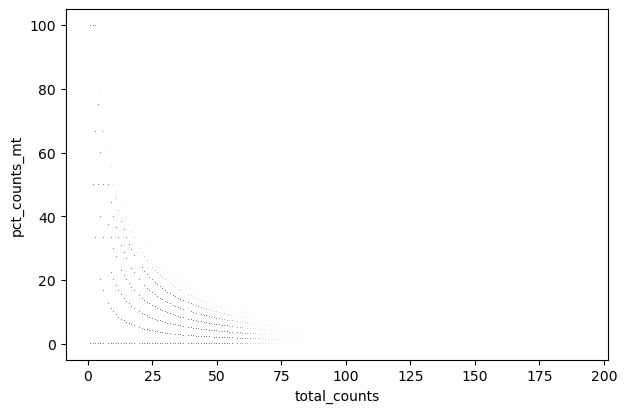

In [6]:
# Plot QC
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

In [ ]:

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)


AttributeError: 'NoneType' object has no attribute '_sanitize'

/opt/anaconda3/envs/spatial_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/spatial_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


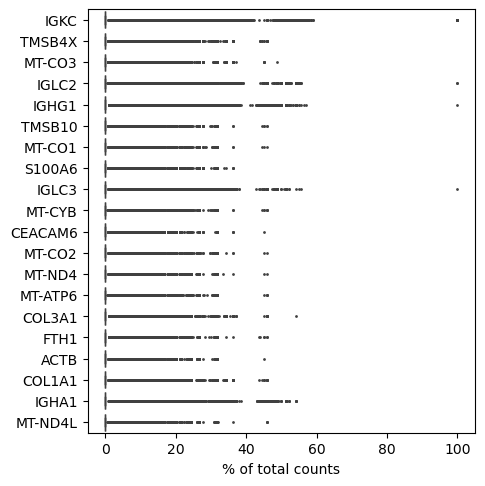

In [2]:
# Filter out extremely low-count bins, but keep most signal
sc.pp.filter_cells(adata, min_counts=5)
sc.pp.filter_genes(adata, min_cells=5)


# Normalize and log1p
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Plot total counts after normalization
sc.pl.highest_expr_genes(adata, n_top=20)

In [6]:

sns.histplot(adata.obs['total_counts'], bins=100)
plt.title("Total Counts per 2µm bin")
plt.xlim(0, 500)  # adjust range based on your data
plt.show()

sns.histplot(adata.obs['n_genes_by_counts'], bins=100)
plt.title("Detected Genes per 2µm bin")
plt.xlim(0, 200)  # adjust range
plt.show()


KeyError: 'total_counts'

In [8]:
import pandas as pd

# Load coordinates from Space Ranger output (adjust path as needed)
parquet_path = "/Users/mounim/Documents/IMMUNEX_data/OUTPUT/spaceranger_output/Visium_NSCLC_IMMUNEX001/outs/binned_outputs/square_002um/spatial/tissue_positions.parquet"
coords = pd.read_parquet(parquet_path)
display(coords.head())

coords.columns = ["barcode", "in_tissue", "array_row", "array_col", "pxl_row_in_fullres", "pxl_col_in_fullres"]
coords.set_index("barcode", inplace=True)

# Match coordinates to AnnData barcodes
adata.obs = adata.obs.join(coords, how="left")
adata = adata[adata.obs["pxl_row_in_fullres"].notnull()]  # Keep spatially located bins

# Add spatial coordinates
adata.obsm["spatial"] = adata.obs[["pxl_row_in_fullres", "pxl_col_in_fullres"]].values


,barcode,in_tissue,array_row,array_col,pxl_row_in_fullres,pxl_col_in_fullres
0,s_002um_00000_00000-1,1,0,0,43197.525900,85631.376952
1,s_002um_00000_00001-1,1,0,1,43197.606586,85622.631939
2,s_002um_00000_00002-1,1,0,2,43197.687271,85613.886926
3,s_002um_00000_00003-1,1,0,3,43197.767957,85605.141913
4,s_002um_00000_00004-1,1,0,4,43197.848643,85596.396900


ValueError: columns overlap but no suffix specified: Index(['in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres',
       'pxl_col_in_fullres'],
      dtype='object')

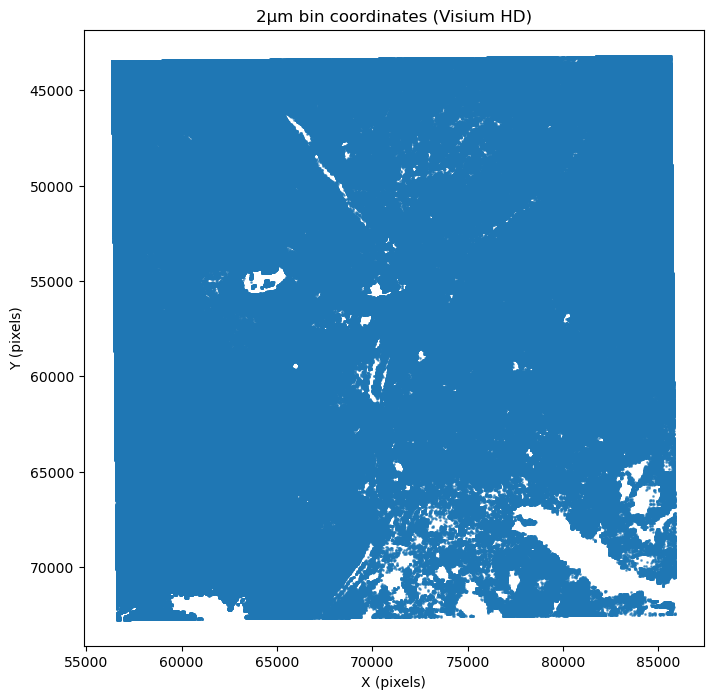

In [9]:
import matplotlib.pyplot as plt

# Plot the 2µm bin coordinates
x = adata.obsm['spatial'][:, 1]  # col (x-axis)
y = adata.obsm['spatial'][:, 0]  # row (y-axis)

plt.figure(figsize=(8, 8))
plt.scatter(x, y, s=1, alpha=0.6)
plt.gca().invert_yaxis()
plt.title("2µm bin coordinates (Visium HD)")
plt.xlabel("X (pixels)")
plt.ylabel("Y (pixels)")
plt.axis("equal")
plt.show()


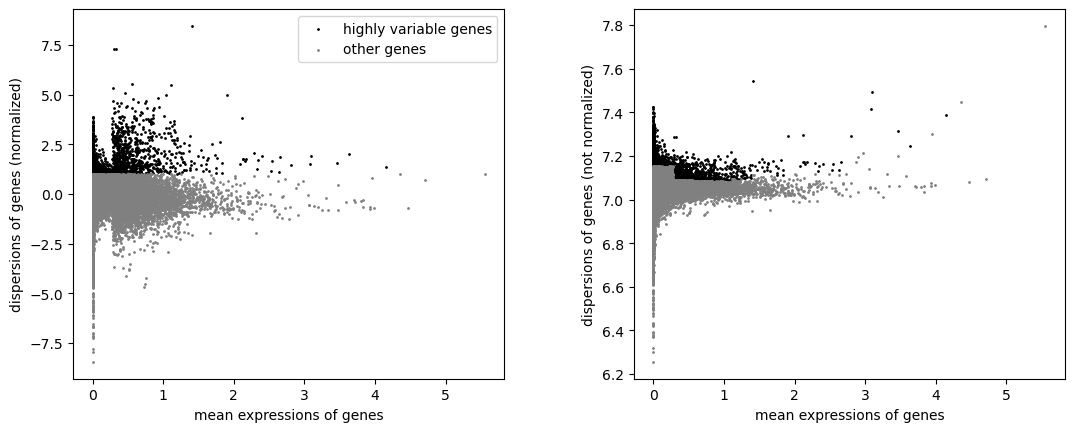

/opt/anaconda3/envs/spatial_env/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


: 

In [10]:
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)
sc.pl.highly_variable_genes(adata)

adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata, log=True)

# Neighbors and clustering
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)

# Visualize clustering
sc.pl.umap(adata, color=["leiden"], title="Leiden clusters")


In [ ]:
# Show spatial clustering
sq.pl.spatial_scatter(adata, color="leiden", size=1.0, title="Leiden clusters (spatial)")


In [ ]:
# Build spatial neighbors graph
sq.gr.spatial_neighbors(adata, coord_type="grid")

# Spatial autocorrelation (Moran’s I)
sq.gr.spatial_autocorr(adata, mode="moran")
sq.pl.spatial_autocorr(adata, mode="moran", genes=adata.var.highly_variable[:6].tolist())
